In [1]:
import pytesseract
from PIL import Image,ImageEnhance
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def crop_book_page(image_path):
    im = cv2.imread(image_path)
    print(im.shape[:2])
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        cropped = im[y:y+h, x:x+w]
        print(cropped.shape[:2])

        return cropped
    else:
        print("No contours found. Returning original image.")
        return im

input_image_path = 'Images/013.jpg'
image = crop_book_page(input_image_path)

(4262, 2845)
(4262, 2845)


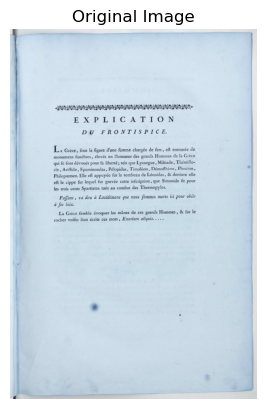

In [3]:
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [4]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
height , width = gray_image.shape[:2]

In [6]:
data = pytesseract.image_to_data(gray_image, output_type=pytesseract.Output.DICT, lang='fra')
n_boxes = len(data['level'])

In [7]:
mask = np.zeros_like(gray_image)
for i in range(n_boxes):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    if w > 0 and h > 0 and w<width and h<height:  # Ensure the width and height are positive
        cv2.rectangle(mask, (x, y), (x + w, y + h), 255, -1)  # Fill the rectangle with white

In [8]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
clean_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
clean_mask = cv2.morphologyEx(clean_mask, cv2.MORPH_OPEN, kernel)

In [9]:
cv2.imwrite('masked_image.jpg', clean_mask)

True

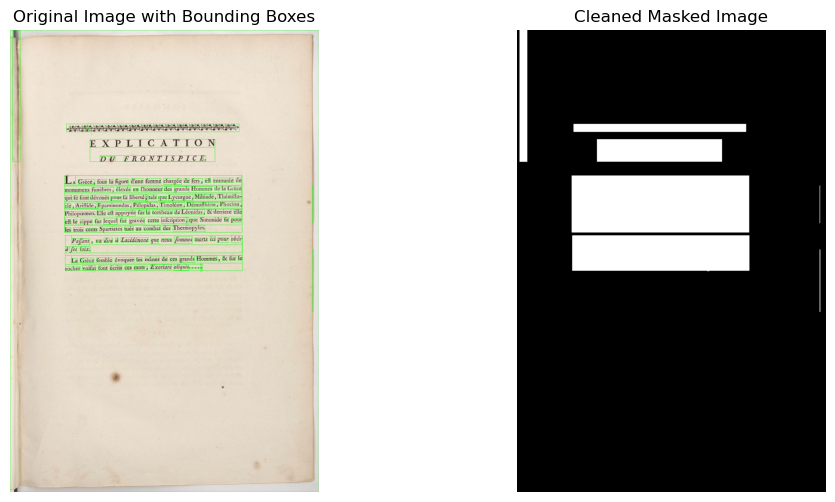

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(n_boxes):
    (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
    if w > 0 and h > 0:  # Ensure the width and height are positive
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title('Original Image with Bounding Boxes')

ax[1].imshow(clean_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Cleaned Masked Image')

plt.show()

In [11]:
text = pytesseract.image_to_string(gray_image, lang='fra')

In [12]:
text

"Fs\n\n2 '\n\nEXPLICATEON\nD@ FRONTISPICE\n\nLA Grèce,, fous la figure d'une femme chargée de fers, eft entourée de\nmonumens funèbres, élevés en l'honneur des grands Hommes de la Grèce\nqui fe font dévoués pour fa liberté ; tels que Lycurgue, Miltiade , Thémifta-\ncle , Ariftide , Epaminondas, Pélopidas, Timoléon, Démofthène, Phocion,\nPhilopæmen. Elle eft appuyée fur le tombeau de Léonidas, & derriere elle\neft le cippe fur lequel fut gravée cette infcription , que Simonide fit pour\nles trois cents Spartiates tués au combat des Thermopyles.\n\nPaffant , va dire à Lacédémone que nous fommes morts ici pour obéir\nà fes loix.\n\nLa Grèce femble évoquer les mânes de ces grands Hommes , & fur le\nrocher voifin font écrits ces mots, Exoriare aliquis. ... .\n\n"

## Translation

In [13]:
from transformers import MarianMTModel, MarianTokenizer

# Load the model and tokenizer
model_name = 'Helsinki-NLP/opus-mt-fr-en'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

C:\Users\pavan\AppData\Roaming\Python\Python311\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [14]:
def translate(text, model, tokenizer, max_length=512):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
    
    # Perform the translation
    translated_tokens = model.generate(**inputs)
    
    # Decode the translated tokens to get the translated text
    translated_text = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
    return translated_text[0]

In [15]:
def split_text(text, tokenizer, max_length=512):
    words = text.split()
    chunks = []
    current_chunk = []
    
    for word in words:
        current_chunk.append(word)
        if len(tokenizer(' '.join(current_chunk))['input_ids']) >= max_length:
            current_chunk.pop()  # Remove last word to keep within max_length
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]  # Start new chunk with the last word
    
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

In [16]:
chunks = split_text(text, tokenizer)

# Translate each chunk and combine the results
english_translations = [translate(chunk, model, tokenizer) for chunk in chunks]
full_translation = '\n'.join(english_translations)
print(full_translation)

Fs 2'EXPLICATEON D@ FRONTISPICE LA grèce,, crazy the figure of a woman in charge of irons, eft surrounded by funeral monumens, raised in honor of the great Men of Greece who are devoted for fa freedom; such as Lycurgue, Miltiade, Thémifta- cle, Ariftide, Epaminondas, Pelopidas, Timoleon, Demofthene, Phocion, Philopæmen. She is supported by the tomb of Léonidas, and behind her the cippe which was engraved this incription, which Simonide made for the three hundred Spartans killed in the fight of the Thermopyles. Paffant, will tell Lacedemone that we are dead here to obey his law. Greece seems to evoke the donkeys of these great Men, & in the verifin rock make these words written, Exoriare aliquis.....


### Evalutaion of translation

In [33]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
import sacrebleu
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
def calculate_metrics(reference, hypothesis):
    # BLEU using NLTK
    reference_tokens = nltk.word_tokenize(reference)
    hypothesis_tokens = nltk.word_tokenize(hypothesis)
    nltk_bleu = sentence_bleu([reference_tokens], hypothesis_tokens)
    
    # Prepare the data for sacrebleu (it expects lists)
    references = [reference]
    hypotheses = [hypothesis]
    
    # Calculate BLEU
    bleu = sacrebleu.sentence_bleu(hypothesis, [reference])
    
    # Calculate chrF
    chrf = sacrebleu.sentence_chrf(hypothesis, [reference])
    
    # Calculate TER
    ter = sacrebleu.sentence_ter(hypothesis, [reference])
        
    return {
        'NLTK BLEU': nltk_bleu,
        'sacreBLEU': bleu.score,
        'chrF': chrf.score,
        'TER': ter.score,
    }

# Calculate metrics
metrics = calculate_metrics(reference, hypothesis)

# Print results
print(f"Reference: {text}")
print(f"Hypothesis: {full_translation}")
print("\nMetrics:")
for metric, score in metrics.items():
    print(f"{metric}: {score}")

Reference: Fs

2 '

EXPLICATEON
D@ FRONTISPICE

LA Grèce,, fous la figure d'une femme chargée de fers, eft entourée de
monumens funèbres, élevés en l'honneur des grands Hommes de la Grèce
qui fe font dévoués pour fa liberté ; tels que Lycurgue, Miltiade , Thémifta-
cle , Ariftide , Epaminondas, Pélopidas, Timoléon, Démofthène, Phocion,
Philopæmen. Elle eft appuyée fur le tombeau de Léonidas, & derriere elle
eft le cippe fur lequel fut gravée cette infcription , que Simonide fit pour
les trois cents Spartiates tués au combat des Thermopyles.

Paffant , va dire à Lacédémone que nous fommes morts ici pour obéir
à fes loix.

La Grèce femble évoquer les mânes de ces grands Hommes , & fur le
rocher voifin font écrits ces mots, Exoriare aliquis. ... .


Hypothesis: Fs 2'EXPLICATEON D@ FRONTISPICE LA grèce,, crazy the figure of a woman in charge of irons, eft surrounded by funeral monumens, raised in honor of the great Men of Greece who are devoted for fa freedom; such as Lycurgue, Miltiade, T